In [1]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

train_embs = pickle_load(r"D:/train_embs.pkl")
test_embs = pickle_load(r"D:/test_embs.pkl")
train_df = pd.read_csv('train.csv')

In [2]:
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


In [3]:
from collections import defaultdict
from tqdm import tqdm

def dict2list(embs):
    keys = list(embs.keys())
    values = [embs[k] for k in keys]
    return keys, np.stack(values)

def compute_sim(train_embs, test_embs):
    # Compute center of each individual id
    label2emb = defaultdict(list)
    for label, d in train_df.groupby('individual_id'):
        for img_id in d.image.values:
            if img_id in train_embs:
                label2emb[label].append(train_embs[img_id])

    for k, v in label2emb.items():
        avg = np.mean(np.stack(v), 0)
        label2emb[k] = avg / np.linalg.norm(avg)

    train_k, train_v = dict2list(label2emb)
    test_k, test_v = dict2list(test_embs)

    cos = np.matmul(test_v, train_v.T)

    records = []

    for i, scores in enumerate(tqdm(cos)):
        sort_idx = np.argsort(scores)[::-1]
        top5 = [train_k[j] for j in sort_idx[:5]]

        for j in range(5):
            sim_score = scores[sort_idx[j]]
            if j == 1:#sim_score < 0.5:
                top5 = top5[:j] + ['new_individual'] + top5[j:4]
                break
            
        records.append([test_k[i], " ".join(top5)])

    sim_df = pd.DataFrame(records, columns=['image', 'predictions'])
    sim_df[["image", "predictions"]].to_csv("submission.csv", index=False)
    return sim_df

sim_df = compute_sim(train_embs, test_embs)
sim_df.head()

100%|██████████| 27956/27956 [00:23<00:00, 1182.20it/s]


,image,predictions
0,6bf8889c9360e5.jpg,0c0243b6d468 new_individual 7a75d5e8c3f1 0aefd...
1,a812d942e6c640.jpg,513e01a14676 new_individual fc18d4bb4137 b72e8...
2,e1a53fb8dc3092.jpg,56b33778c9ce new_individual 67e27ab03638 ab80d...
3,720eb1d0e4320f.jpg,cd59763c9687 new_individual 8b2c506e7790 6ef90...
4,0caa5bc3ee4297.jpg,0f71e50dfef4 new_individual 06ef73efe924 79c94...


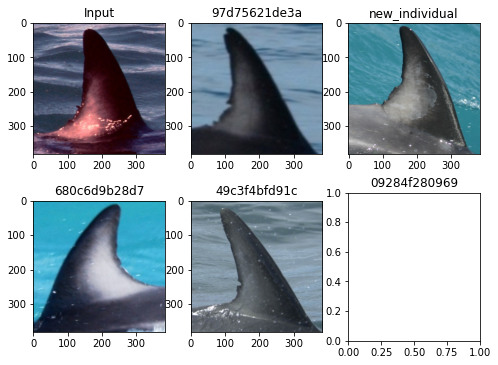

In [50]:
def random_show(sim_df):
    sample = sim_df.iloc[np.random.choice(sim_df.index)]
    img1 = cv2.imread(f'D:/whale_data/test_images-384-384/test_images-384-384/{sample.image}')[:, :, ::-1]
    imgs = [img1]

    ids = sample.predictions.split(" ")
    for i in range(5):
        if ids[i] != 'new_individual':
            path = train_df[train_df.individual_id == ids[i]].values[0][0]
            img = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{path}')[:, :, ::-1]
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i == 0:
            plt.title('Input')
        else:
            plt.title(ids[i-1])
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(sim_df)

In [17]:
raise
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=100,metric='cosine')

train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [18]:
distances, idxs = knn.kneighbors(test_v, 100, return_distance=True)

In [37]:
test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d]) 
    

test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

100%|██████████| 27956/27956 [00:04<00:00, 6721.14it/s]


1      487
37     405
34     395
36     387
33     387
      ... 
96     161
97     122
98     117
99      75
100     30
Name: image, Length: 100, dtype: int64

In [41]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']


In [42]:
predictions = {}
for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence > 0.5:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

100%|██████████| 27956/27956 [00:00<00:00, 1126897.73it/s]


,image,predictions
0,2e9e1d75f4fba3.jpg,4 4 5 2 7 0 d 9 a d 5 2 n e w _ i n d i v i ...
1,1b665b05967efa.jpg,5bf17305f073 new_individual 5f48c2296a0e aff93...
2,0f4a874848896a.jpg,5bf17305f073 new_individual 5f48c2296a0e aff93...
3,0b994f6d9e3e2a.jpg,0e4660baf3f1 new_individual c2705f9e75c8 b9907...
4,2e844096691039.jpg,445270d9ad52 new_individual 7e5ae959f2d5 649cb...
